In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [2]:
import geomloss
import matplotlib.pyplot as plt
import numpy as np
import ot
import pandas as pd
import scipy.stats as st
import seaborn
import torch
import math

In [3]:
from pflow.optimal_transport.transportation_plan import transport_from_potentials, reweight

In [4]:
def systematic_resample(weights, randomState):
    N = len(weights)

    positions = (randomState.random() + np.arange(N)) / N

    indexes = np.zeros(N, dtype = int)
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes


In [5]:
def draw_uniform_within_circle(n, r, randomState):
    accepted = 0
    sample = np.zeros((n, 2), dtype = float)
    pct_accepted_in_avg = np.pi / 4.
    while accepted < n:
        nb_draw = int((n-accepted)/pct_accepted_in_avg) + 1
        proposal = randomState.uniform([-r, -r], [r, r], (nb_draw, 2))
        mask = (proposal ** 2).sum(axis=1) <= 1
        keep = proposal[mask]
        new_number = min(n, accepted + len(keep))
        sample[accepted:new_number] = keep[:new_number-accepted]
        accepted = new_number
    return sample

In [6]:
cpu = torch.device('cpu')

$X \sim \sum_i w_i, \delta_{X_i}$ where the $X_i$'s are i.i.d. $U([-2, 2])$ and $w_i \propto f(X_i)$ where $f$ is the pdf of a normal distribution $ \mathcal{N}(1, 1)$

In [8]:
randomState = np.random.RandomState(42)
N = 500

In [8]:
X = randomState.uniform(-2, 2, (N,) )

loc=0.5
scale=0.25
weights = st.norm.pdf(X, loc=-0.5, scale=0.25)
random_index = randomState.choice(N, 250, False)
weights[random_index] = st.norm.pdf(X[random_index], loc=loc, scale=scale)
weights /= weights.sum()

In [9]:
uniform_weights = np.full(N, 1/N)

Illustration of the regularised OT problem:

In [10]:
exactTransport = ot.bregman.empirical_sinkhorn(X[:, None], X[:, None], 1e-2, uniform_weights, weights)
# sadly the Earth moving distance doesn't work

In [11]:
torch_uniform_weights = torch.from_numpy(uniform_weights).to(cpu)
torch_X = torch.from_numpy(X[:, None]).to(cpu)
torch_weights = torch.from_numpy(weights).to(cpu)

In [12]:
epsilons = [0.01, 0.05, 0.1, 0.5]
approximateTransports = []
for eps in epsilons:
    biasedSampleLoss = geomloss.SamplesLoss(reach=None, potentials=True, debias=False, scaling=0.9, blur=eps)    
    approximateTransports.append(reweight(torch_X, torch_weights, biasedSampleLoss, eps, 2))

In [13]:
linspace = np.sort(np.random.uniform(-3, 3, 10000))
theoretical_unweighted = st.norm.pdf(linspace, loc=loc, scale=scale)


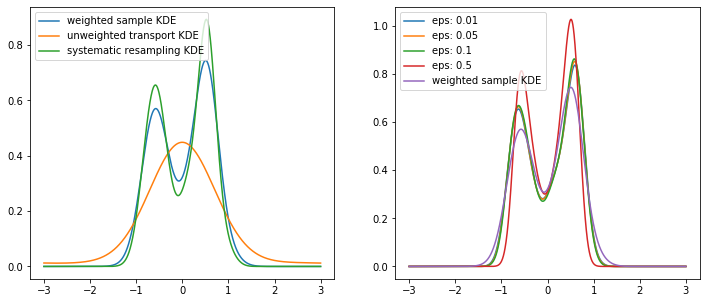

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

weighted_sample_kde = st.kde.gaussian_kde(X, weights=weights)
exact_transport_kde = st.kde.gaussian_kde((exactTransport.T * N) @ X)

systematic_index = systematic_resample(weights, randomState)
systematic_resampling_kde = st.kde.gaussian_kde(X[systematic_index])

_ = axes[0].plot(linspace, weighted_sample_kde(linspace), label='weighted sample KDE')
_ = axes[0].plot(linspace, exact_transport_kde(linspace), label='unweighted transport KDE')
_ = axes[0].plot(linspace, systematic_resampling_kde(linspace), label='systematic resampling KDE')

dataframeWeights = []

for eps, plan in zip(epsilons, approximateTransports):
    approx_transport_kde = st.kde.gaussian_kde(plan[0].detach().numpy().squeeze(), weights=plan[1].detach().numpy())
    dataframeWeights.append(pd.Series(data=plan[1].detach().numpy().squeeze(), name=eps))
    _ = axes[1].plot(linspace, approx_transport_kde(linspace), label=f'eps: {eps}')
    
_ = axes[1].plot(linspace, weighted_sample_kde(linspace), label='weighted sample KDE')


_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')

fig.savefig( 'DegenerateTransport.png')

In [15]:
unbiasedLoss = geomloss.SamplesLoss(reach=None, potentials=False, debias=True, scaling=0.9, blur=eps)

In [16]:
epsilon = 0.1
loss = geomloss.SamplesLoss(debias=True, blur=epsilon)
var = torch_X.clone()
var.requires_grad = True

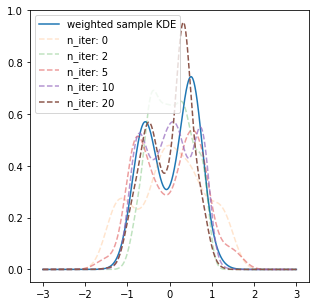

In [17]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

weighted_sample_kde = st.kde.gaussian_kde(X, weights=weights)
_ = ax.plot(linspace, weighted_sample_kde(linspace), label='weighted sample KDE')

lr = 0.5
n_iter = 21
opt = torch.optim.Adam(lr = lr, params=[var])
for i in range(n_iter):
    
    opt.zero_grad()
    res = loss(torch_uniform_weights, var, torch_weights, torch_X)
    res.backward()
    opt.step()
    approx_transport_kde = st.kde.gaussian_kde(var.detach().numpy().squeeze(), weights=uniform_weights)
    if i in [0, 2, 5, 10, 20]:
        _ = ax.plot(linspace, approx_transport_kde(linspace), label=f'n_iter: {i}', alpha = min(1, 0.05 * i + 0.2), linestyle='--')
    
_ = ax.legend(loc='upper left')
fig.savefig('LearntDist.png')

# Example in 2D

(-1.2, 1.2)

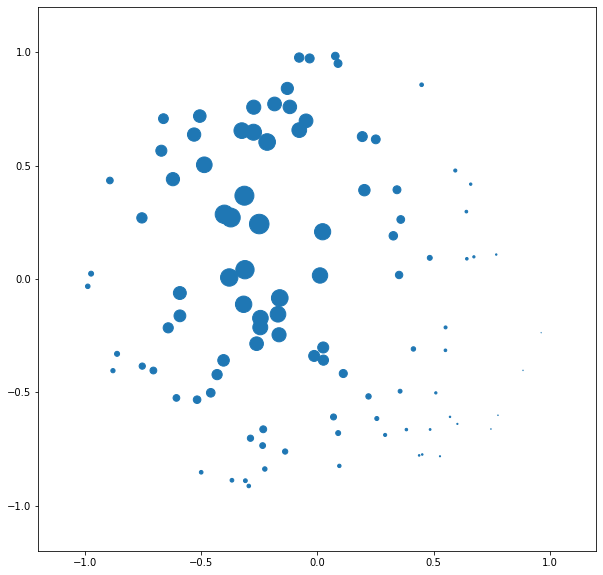

In [107]:
vals = draw_uniform_within_circle(100, 1, randomState)
weights_2d = st.multivariate_normal.pdf(vals, [-0.25, 0.25], [[0.1, 0.], [0., 0.2]])
weights_2d /= weights_2d.sum()
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(vals[:, 0], vals[:, 1], s=weights_2d * 10000)
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)



In [170]:
X_2d_torch = torch.tensor(vals)
w_2d_torch = torch.tensor(weights_2d)

In [171]:
def iterative_learnt(loss, X, w, substeps = 5, lr = 1., nSteps=6, savefig=True):
    import time
    # only in 2D
    ts = np.linspace(0., 1., nSteps+1)

    x_i, x_j = X.clone(), X.clone()
    x_i.requires_grad = True
    
    # Use colors to identify the particles
    colors = (10*X[:,0]).cos() * (10*X[:,1]).cos()
    colors = colors.detach().cpu().numpy()
    
    t_0 = time.time()
    nLines = math.ceil((nSteps+1)/3)
    plt.figure(figsize=(15,5*nLines))
    
    k = 1

    ax = plt.subplot(nLines,3,k) ; k = k+1
    cp = display_samples(ax, X, w.detach().numpy(), colors, with_cp=True)
    ax.set_title("Original degenerate sample")
    
    ones = torch.ones_like(w, requires_grad=False) / len(w)
    cps = []
    tocs = 0.
    for i in range(nSteps):
        tic = time.time()
        w_i  = w * (1-ts[i]) + ones * ts[i]
        w_i_1 = w * (1-ts[i+1]) + ones * ts[i+1]
        for _ in range(substeps):
            L_αβ = loss(w_i_1, x_i, w_i, x_j)
            [g]  = torch.autograd.grad(L_αβ, [x_i])
            x_i.data -= lr * g * len(w)
        tocs += time.time() - tic

        ### plot
        ax = plt.subplot(nLines,3,k) ; k = k+1

        
#         display_samples(ax, x_j, w_i.detach().numpy(), (.55,.55,.95), with_cp=False)
        cp = display_samples(ax, x_i, w_i_1.detach().numpy(), colors, with_cp=True)
        cps.append(cp)
        
        ax.set_title("t = {:1.2f}".format(lr*i))
        plt.axis([-1, 1, -1, 1])
        plt.tight_layout()
    
        x_j.data.copy_(x_i.data)
        # in-place modification of the tensor's values
        
    plt.suptitle("Evolution of reweighting, elapsed time: {:.2f}s/it".format(tocs/nSteps), y=1.05)
    if savefig:
        fig.savefig('IterativeReweighting.png')
    

In [172]:
def learn_best(loss, X, w, lr = 1., nSteps=6, savefig=True):
    import time
    # only in 2D
    x_i, x_j = X.clone(), X.clone()
    x_i.requires_grad = True
    
    # Use colors to identify the particles
    colors = (10*X[:,0]).cos() * (10*X[:,1]).cos()
    colors = colors.detach().cpu().numpy()
    
    tocs = 0.   
    nLines = math.ceil((nSteps + 1)/3)
    fig, axes = plt.subplots(ncols=3, nrows=nLines, figsize=(15,5*nLines), sharex=True, sharey=True)
    axes = iter(axes.flatten())
    ones = torch.ones_like(w, requires_grad=False) / len(w)
    cps = []
    
    ax = next(axes)
    cp = display_samples(ax, X, w.detach().numpy(), colors, with_cp=True)
    ax.set_title("Original degenerate sample")
    for i in range(nSteps):
        tic = time.time()
        L_αβ = loss(ones, x_i, w, X)
        [g]  = torch.autograd.grad(L_αβ, [x_i])
        x_i.data -= lr * g * len(w)
        tocs += time.time() - tic
        ### plot
        ax = next(axes)
        cp = display_samples(ax, x_i, ones.detach().numpy(), colors, with_cp=True)
        ax.set_title("t = {:1.2f}".format(lr*i))
        plt.axis([-1, 1, -1, 1])
#             plt.xticks([], []); plt.yticks([], [])
        plt.tight_layout()
    
#         x_j.data.copy_(x_i.data)
        # in-place modification of the tensor's values
        
    fig.suptitle("Evolution of reweighting, elapsed time: {:.2f}s/it".format(tocs/nSteps), y=1.05)
    if savefig:
        fig.savefig('LearntReweighting.png')
    

In [173]:
def biasedTransportComparison(X, w, eps=0.1, savefig=True):
    from pflow.optimal_transport.transportation_plan import Transport
    from pflow.resampling.systematic import SystematicResampling
    import time
    
    transport = Transport(eps, scaling=0.9, reach=5)
    systematic = SystematicResampling()
    
    # Use colors to identify the particles
    colors = (10*X[:,0]).cos() * (10*X[:,1]).cos()
    colors = colors.detach().cpu().numpy()
    
    fig, axes = plt.subplots(ncols=3, figsize=(15,5), sharex=True, sharey=True)
    
    cps = []
    tic = time.time()
    transported_x, transported_w = transport.apply(X, w)
    toc = time.time()
    resampled_x, resampled_w = systematic.apply(X, w)
    
    cp_original = display_samples(axes[0], X, w.detach().cpu().numpy(), colors, with_cp=True)
    axes[0].set_title("Original degenerate sample")

    cp_systematic = display_samples(axes[1], resampled_x, resampled_w.detach().cpu().numpy(), colors, with_cp=True)
    axes[1].set_title("Systematic resample")
    
    cp_transported = display_samples(axes[2], transported_x, transported_w.detach().cpu().numpy(), colors, with_cp=True)
    axes[2].set_title("Transported reweighting")
    
    plt.axis([-1, 1, -1, 1])
#             plt.xticks([], []); plt.yticks([], [])
    plt.tight_layout()

    plt.suptitle("Comparison of reweighting schemes, elapsed time: {:.2f}s".format((toc-tic)), y=1.05)
    if savefig:
        fig.savefig('BiasedTransport.png')
    

In [174]:
def display_samples(ax, x, w, color, with_cp) :
    import seaborn as sns
    x_ = x.detach().cpu().numpy()
    ax.scatter( x_[:,0], x_[:,1], 5000*w, color, edgecolors='none', alpha= 1. )
    mesh_vals = np.linspace(-1., 1., 50)
    mesh = np.meshgrid(mesh_vals, mesh_vals)
    kde = st.kde.gaussian_kde(x_.T, weights = w)
    mesh_vals = np.stack([mesh[0], mesh[1]], axis=0).reshape(2, -1)
    kde_val = kde(mesh_vals).reshape(*mesh[0].shape)

#     kde_vals = [kde(mesh_x, mesh_y)]
    if with_cp:
        cp = ax.contourf(mesh[0], mesh[1], kde_val, alpha=0.3)
        return cp

    

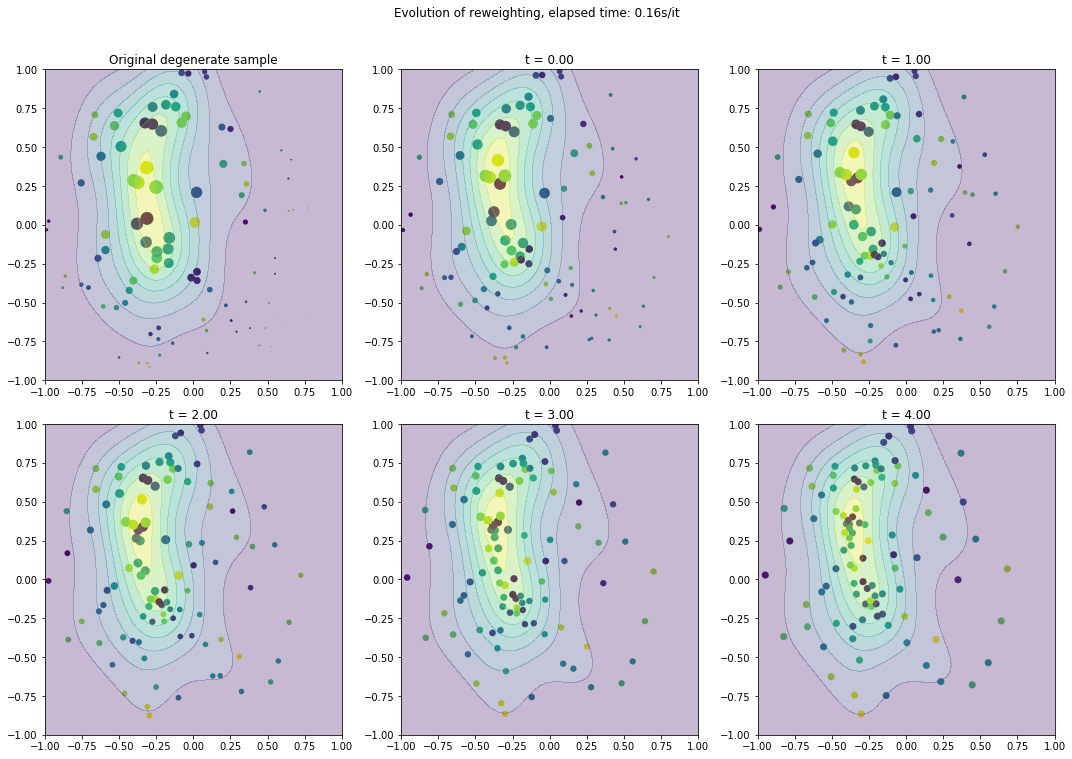

In [182]:
unbiasedLoss = geomloss.SamplesLoss(reach=5, potentials=False, debias=True, scaling=0.9, blur=0.1)
iterative_learnt(unbiasedLoss, X_2d_torch, w_2d_torch, 3, 1., nSteps=5)

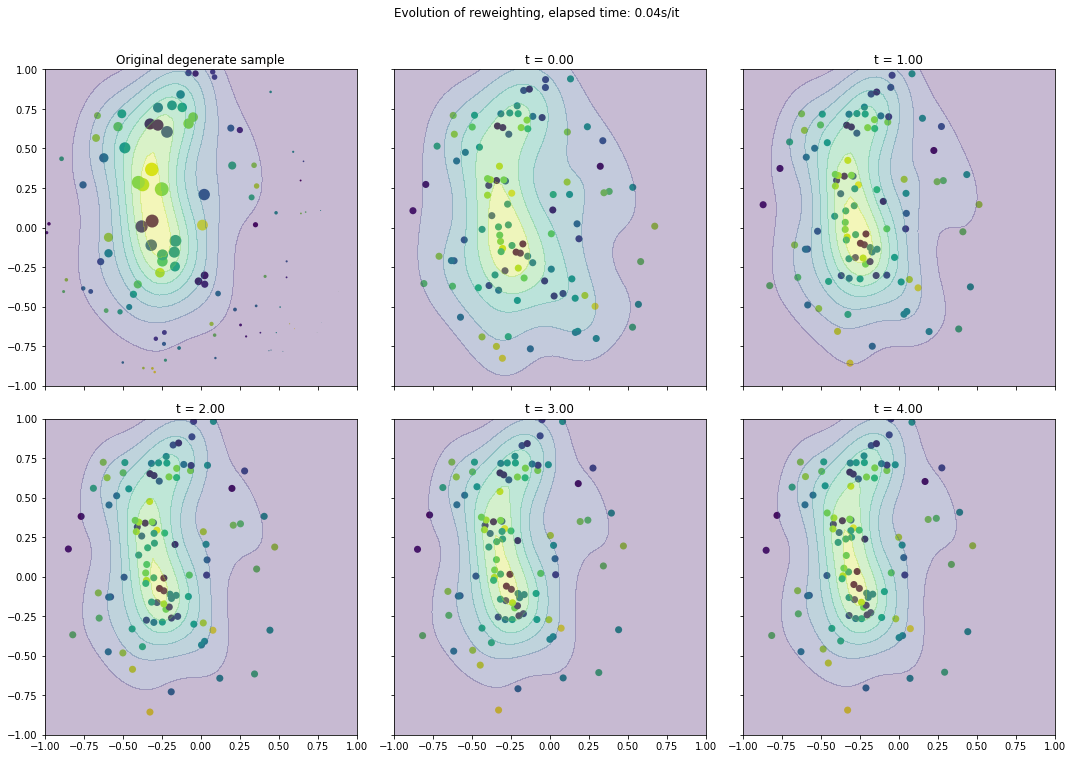

In [180]:
unbiasedLoss = geomloss.SamplesLoss(reach=1, potentials=False, debias=True, scaling=0.9, blur=0.1)
learn_best(unbiasedLoss, X_2d_torch, w_2d_torch, 1., nSteps=5)

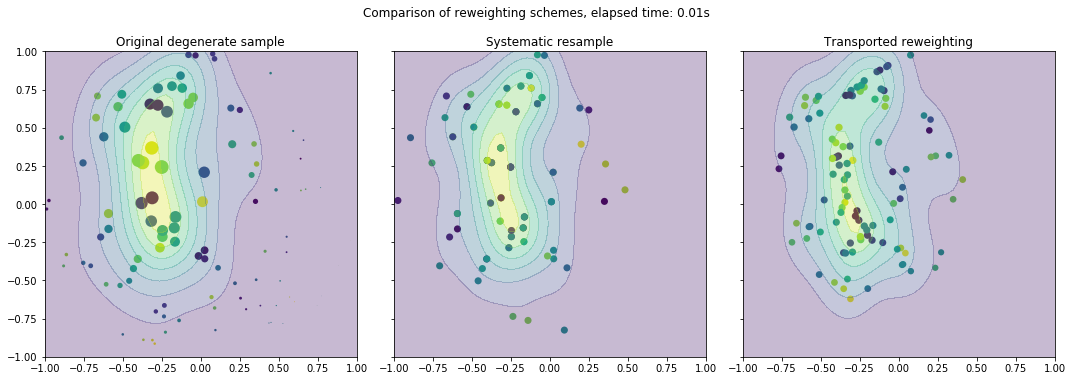

In [181]:
biasedTransportComparison(X_2d_torch, w_2d_torch, 0.1)